# Загрузка библиотек

In [7]:
# данные
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import math

# визуализация
from matplotlib import pyplot as plt
import seaborn as sns

# подготовка данных
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# отбор признаков
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# метрики
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

# регресия
from sklearn.linear_model import LinearRegression, Lasso
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# классификация
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier

# Загрузка и анализ данных

In [84]:
# прочитаем файл csv с историческими данными
parse_dates = ['<DATE>']
data = pd.read_csv('SBER_100101_230501.csv', parse_dates=parse_dates)
data.drop(columns=['<TICKER>', '<PER>', '<TIME>'], inplace=True)
data.head(2)

,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,2010-01-11,86.56000,88.17000,85.51000,86.69000,148661237
1,2010-01-12,86.55000,86.77000,84.90000,85.00000,130276079


In [85]:
# переименуем названия признаков в более удобные
data.rename(columns={'<TICKER>':'TICKER', '<DATE>':'DATE', '<OPEN>':'OPEN', '<HIGH>':'HIGH', 
                     '<LOW>':'LOW', '<CLOSE>':'CLOSE', '<VOL>':'VOL'}, inplace=True)
data.head(2)

,DATE,OPEN,HIGH,LOW,CLOSE,VOL
0,2010-01-11,86.56000,88.17000,85.51000,86.69000,148661237
1,2010-01-12,86.55000,86.77000,84.90000,85.00000,130276079


In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    3333 non-null   datetime64[ns]
 1   OPEN    3333 non-null   float64       
 2   HIGH    3333 non-null   float64       
 3   LOW     3333 non-null   float64       
 4   CLOSE   3333 non-null   float64       
 5   VOL     3333 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 156.4 KB


<Axes: >

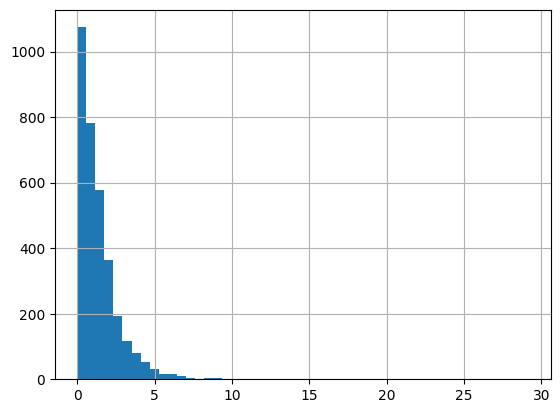

In [87]:
# на сколько процентов в среднем в день "ходит" цена
abs((data['OPEN'] - data['CLOSE']) / data['OPEN'] * 100).hist(bins=50)

In [88]:
(abs((data['OPEN'] - data['CLOSE']) / data['OPEN'] * 100)).describe()

count   3333.00000
mean       1.37796
std        1.46670
min        0.00000
25%        0.44997
50%        1.01810
75%        1.82260
max       29.15639
dtype: float64

В среднем акция "ходит" на 1,5% за день. Максимальное значение было почти 30% за день.

## Удаление выбросов

Пробовал варианты без удаления выбросов и с удалением. Выбросными считаю записи, когда происходило резкое изменение цены (больше 10%). Вариант с удалением дает улучшение, но совсем немного (десятые доли процента mape).

In [89]:
data.loc[(data['OPEN'] - data['CLOSE']) / data['OPEN']*100 > 10]

,DATE,OPEN,HIGH,LOW,CLOSE,VOL
1240,2014-12-16,59.50000,61.95000,47.21000,53.50000,470470430
2070,2018-04-09,255.10000,255.30000,205.00000,213.00000,249893540
3050,2022-02-21,249.12000,258.32000,184.30000,201.00000,1084339130
3052,2022-02-24,186.58000,187.54000,89.59000,132.18000,828329350


In [90]:
drop_idx = data.loc[(data['OPEN'] - data['CLOSE']) / data['OPEN']*100 > 10].index
drop_idx

Int64Index([1240, 2070, 3050, 3052], dtype='int64')

In [91]:
data.drop(index=drop_idx, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3329 entries, 0 to 3332
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    3329 non-null   datetime64[ns]
 1   OPEN    3329 non-null   float64       
 2   HIGH    3329 non-null   float64       
 3   LOW     3329 non-null   float64       
 4   CLOSE   3329 non-null   float64       
 5   VOL     3329 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 182.1 KB


<Axes: >

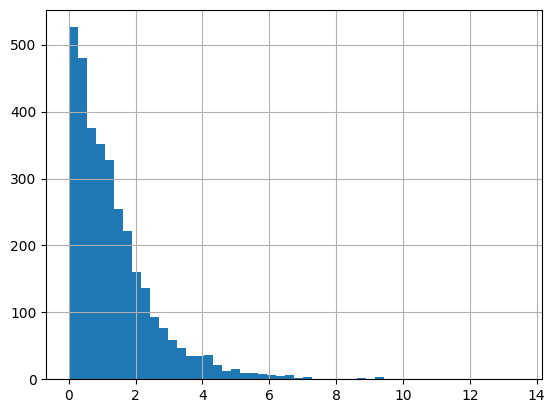

In [120]:
# без выбросов
abs((data['OPEN'] - data['CLOSE']) / data['OPEN'] * 100).hist(bins=50)

# Целевой признак

Для задачи регрессии: предсказание цены закрытия/максимума/минимума 

In [93]:
# целевой признак для регресии - это цена закрытия/максимум/минимум дня
# добавим его смещением признака с ценой закрытия вверх на единицу
data['TARGET_CLOSE'] = data['CLOSE'].shift(-1)
data['TARGET_HIGH'] = data['HIGH'].shift(-1)
data['TARGET_LOW'] = data['LOW'].shift(-1)
data.head(5)

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,TARGET_CLOSE,TARGET_HIGH,TARGET_LOW
0,2010-01-11,86.56000,88.17000,85.51000,86.69000,148661237,85.00000,86.77000,84.90000
1,2010-01-12,86.55000,86.77000,84.90000,85.00000,130276079,86.61000,87.23000,84.10000
2,2010-01-13,84.40000,87.23000,84.10000,86.61000,128684773,87.55000,87.87000,86.75000
3,2010-01-14,87.50000,87.87000,86.75000,87.55000,111263614,88.15000,88.67000,87.16000
4,2010-01-15,87.47000,88.67000,87.16000,88.15000,142060148,90.49000,90.65000,87.79000


In [94]:
# избавимся от nan-ов
data = data.dropna()

# Решение "в лоб"

In [95]:
# предикторы
X = data.drop(columns=['DATE', 'TARGET_CLOSE', 'TARGET_HIGH', 'TARGET_LOW'])
# целевой признак
y = data['TARGET_CLOSE']

# разделим на трейн и тест без перемешивания
# учимся на более ранних данных, тестируем на более поздних
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

Bозмем несколько моделей регресии и обучим их с параметрами по умолчению. В качестве метрики будем использовать MAPE – среднюю абсолютную ошибку в процентах.

In [96]:
reg_models = [
        LinearRegression(),
        Lasso(),
        LGBMRegressor(random_state=10),
        KernelRidge(),
        ElasticNet(random_state=10),
        BayesianRidge(),
        GradientBoostingRegressor(random_state=10),
        SVR(),
        RandomForestRegressor(random_state=10)
        ]

In [97]:
# для записи метрик качества моделей
reg_models_metrics = pd.DataFrame(columns=['model', 'mape'])

for i, model in enumerate(reg_models):
    print(model, end = '..........')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)    
    mape_ = mape(y_test, y_pred)
    reg_models_metrics.loc[len(reg_models_metrics.index)] = [model, mape_]
    print('Ok')

reg_models_metrics 

LinearRegression()..........Ok
Lasso()..........Ok
LGBMRegressor(random_state=10)..........

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.043e+03, tolerance: 6.097e+02
  model = cd_fast.enet_coordinate_descent(


Ok
KernelRidge()..........

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Ok
ElasticNet(random_state=10)..........Ok
BayesianRidge()..........Ok
GradientBoostingRegressor(random_state=10)..........

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.162e+03, tolerance: 6.097e+02
  model = cd_fast.enet_coordinate_descent(


Ok
SVR()..........Ok
RandomForestRegressor(random_state=10)..........Ok


,model,mape
0,LinearRegression(),0.01574
1,Lasso(),0.01585
2,LGBMRegressor(random_state=10),0.04488
3,KernelRidge(),0.01694
4,ElasticNet(random_state=10),0.01587
5,BayesianRidge(),0.01573
6,([DecisionTreeRegressor(criterion='friedman_ms...,0.04147
7,SVR(),0.39118
8,"(DecisionTreeRegressor(max_features=1.0, rando...",0.04154


Несколько моделей показывают похожие результаты - MAPE около 1,6-1,7%. Это соответсвует среднему ходу цены на акции за день. Поэтому такое предсказание не несет особого смысла.

# Feature engineering

На основе имеющихся признаков придумаем новые и попробуем добавить их в модель. Добавим признаки:
- основанные на дате (день недели, месяц)
- основанные на ценах (разность между открытием и закрытием, между максимум и минимуом дня)
- прошлые значения цены. 

Также добавим в признаки цену сегодняшнего открытия и будем делать предсказание уже после открытия рынка.

In [98]:
def features(data):

    # день недели
    data['DAY_OF_WEEK'] = data['DATE'].dt.dayofweek

    # месяц
    data['MONTH'] = data['DATE'].dt.month
    
    # разность между ценой открытия и закрытия
    data['DIF_O_C'] = data['OPEN'] - data['CLOSE']
    
    # разность между максимальной и минимальной ценой
    data['DIF_H_L'] = data['HIGH'] - data['LOW']

    # средние цены закрытия за ... дней
    data['MEAN_2'] = data['CLOSE'].rolling(window=2, center=False).mean()
    data['MEAN_3'] = data['CLOSE'].rolling(window=3, center=False).mean()
    data['MEAN_4'] = data['CLOSE'].rolling(window=4, center=False).mean()
    data['MEAN_5'] = data['CLOSE'].rolling(window=5, center=False).mean()

    # максимальные цены за ... дней
    data['HIGH_2'] = data['HIGH'].rolling(window=2, center=False).max()
    data['HIGH_3'] = data['HIGH'].rolling(window=3, center=False).max()
    data['HIGH_4'] = data['HIGH'].rolling(window=4, center=False).max()
    data['HIGH_5'] = data['HIGH'].rolling(window=5, center=False).max()

    # минимальные цены за ... дней
    data['LOW_2'] = data['LOW'].rolling(window=2, center=False).min()
    data['LOW_3'] = data['LOW'].rolling(window=3, center=False).min()
    data['LOW_4'] = data['LOW'].rolling(window=4, center=False).min()
    data['LOW_5'] = data['LOW'].rolling(window=5, center=False).min()
    
    # цены и объем за прошлые дни
    data[['OPEN_LAG_1', 'HIGH_LAG_1', 'LOW_LAG_1', 'CLOSE_LAG_1', 'VOL_LAG_1']] = data[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']].shift(1)
    data[['OPEN_LAG_2', 'HIGH_LAG_2', 'LOW_LAG_2', 'CLOSE_LAG_2', 'VOL_LAG_2']] = data[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']].shift(2)
    data[['OPEN_LAG_3', 'HIGH_LAG_3', 'LOW_LAG_3', 'CLOSE_LAG_3', 'VOL_LAG_3']] = data[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']].shift(3)
    data[['OPEN_LAG_4', 'HIGH_LAG_4', 'LOW_LAG_4', 'CLOSE_LAG_4', 'VOL_LAG_4']] = data[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']].shift(4)
    data[['OPEN_LAG_5', 'HIGH_LAG_5', 'LOW_LAG_5', 'CLOSE_LAG_5', 'VOL_LAG_5']] = data[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']].shift(5)

  
    # цена открытия сегодня
    data['OPEN_TODAY'] = data['OPEN'].shift(-1)

    data.dropna(inplace=True)

    return pd.get_dummies(data, columns=['DAY_OF_WEEK', 'MONTH'], prefix=['DAY_OF_WEEK', 'MONTH'])

In [99]:
data1 = features(data.copy())
data1.head()

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,TARGET_CLOSE,TARGET_HIGH,TARGET_LOW,DIF_O_C,...,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
5,2010-01-18,87.86000,90.65000,87.79000,90.49000,179399350,92.02000,92.20000,88.80000,-2.63000,...,0,0,0,0,0,0,0,0,0,0
6,2010-01-19,90.52000,92.20000,88.80000,92.02000,268915291,90.62000,92.49000,90.42000,-1.50000,...,0,0,0,0,0,0,0,0,0,0
7,2010-01-20,92.02000,92.49000,90.42000,90.62000,220273259,89.18000,91.65000,88.92000,1.40000,...,0,0,0,0,0,0,0,0,0,0
8,2010-01-21,91.26000,91.65000,88.92000,89.18000,219353508,86.50000,89.06000,85.75000,2.08000,...,0,0,0,0,0,0,0,0,0,0
9,2010-01-22,88.46000,89.06000,85.75000,86.50000,221223200,88.07000,88.80000,85.33000,1.96000,...,0,0,0,0,0,0,0,0,0,0


# Feature Selection
Посмотрим какие из признаков имеют наибольший вес и, в зависимости от этого, отберем наиболее подходящие.

In [100]:
fs = SelectKBest(score_func=f_regression, k='all')
# предикторы
X = data1.drop(columns=['DATE', 'TARGET_CLOSE', 'TARGET_HIGH', 'TARGET_LOW'])
# целевой признак
y = data1['TARGET_CLOSE']
fs.fit(X, y)

SelectKBest(k='all', score_func=<function f_regression at 0x7faa4ce8c790>)

<Axes: >

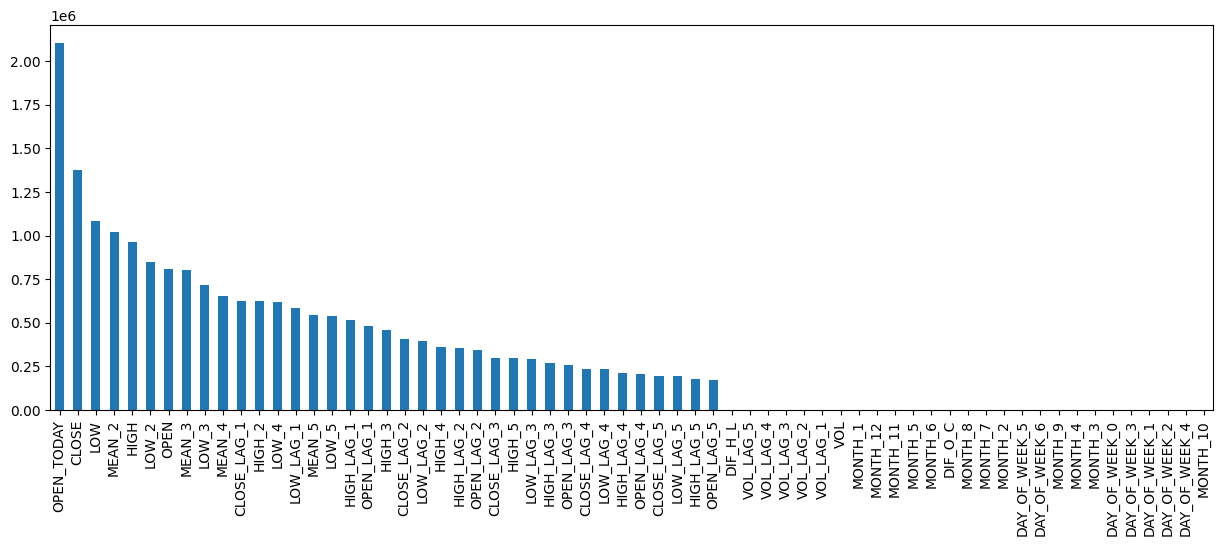

In [101]:
# для удобства визуализируем в виде гистограммы
scores = pd.DataFrame(fs.scores_, fs.get_feature_names_out(), columns=['score']).sort_values(by='score', ascending=False)
scores.score.plot.bar(figsize=(15,5))

# Финальная модель регресии

В качестве финальной модели регресии возьмем линейную регрессию.

## Предсказание CLOSE

In [102]:
model_close = LinearRegression()

Обучим на полном наборе признаков.

In [103]:
# предикторы
X = data1.drop(columns=['DATE', 'TARGET_CLOSE', 'TARGET_HIGH', 'TARGET_LOW'])
# целевой признак
y = data1['TARGET_CLOSE']

# разделим на трейн и тест без перемешивания
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# обучение и результат
model_close.fit(X_train, y_train)
y_pred = model_close.predict(X_test) 
mape(y_test, y_pred)

0.01426119206962078

Попробуем обучить ее только с отобранными признаками.

In [104]:
# отбор признаков
fs = SelectKBest(score_func=f_regression, k=30)
fs.fit(X_train, y_train)

# преобразования
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# обучение и результаты
model_close.fit(X_train_fs, y_train)
y_pred_fs = model_close.predict(X_test_fs) 
mape(y_test, y_pred_fs)

0.014076077093609717

Разница между этими двумя вариантами получается небольшой. В целом результаты стали лучше, но ненамного (1,41% против 1,57%)

## Предсказание HIGH

In [105]:
model_high = LinearRegression()

In [106]:
# предикторы
X = data1.drop(columns=['DATE', 'TARGET_CLOSE', 'TARGET_HIGH', 'TARGET_LOW'])
# целевой признак
y = data1['TARGET_HIGH']

# разделим на трейн и тест без перемешивания
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# отбор признаков
fs = SelectKBest(score_func=f_regression, k=30)
fs.fit(X_train, y_train)

# преобразования
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# обучение и результаты
model_high.fit(X_train_fs, y_train)
y_pred_fs = model_high.predict(X_test_fs) 
mape(y_test, y_pred_fs)

0.00856981881322237

## Предсказание LOW

In [107]:
model_low = LinearRegression()

Обучим на полном наборе признаков.

In [108]:
# предикторы
X = data1.drop(columns=['DATE', 'TARGET_CLOSE', 'TARGET_HIGH', 'TARGET_LOW'])
# целевой признак
y = data1['TARGET_LOW']

# разделим на трейн и тест без перемешивания
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# отбор признаков
fs = SelectKBest(score_func=f_regression, k=30)
fs.fit(X_train, y_train)

# преобразования
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# обучение и результаты
model_high.fit(X_train_fs, y_train)
y_pred_fs = model_high.predict(X_test_fs) 
mape(y_test, y_pred_fs)

0.009030180342985859

Максимум и минимум получается предсказывать точнее, чем закрытие.

# Визуализация результатов

Какие были бы результаты, если использовать полученные предсказания для покупки/продажи бумаги. Для простоты считаем так:

- предсказанная цена закрытия выше цены открытия - покупаем
- предсказанная цена закрытия ниже цены открытия - продаем
- покупается/продается одна акция
- открытие позиции происходит ежедневно по цене открытия дня
- закрытие - по реальной цене закрытия

In [109]:
# для удобства сведем в отдельный датафрейм ...
open_close = pd.DataFrame()
# цену открытия - open
open_close['open'] = X_test['OPEN']
# реальную цену закрытия - close_real
open_close['close_real'] = y_test
# и предсказанные моделями цены закрытия - close_pred
open_close['close_pred'] = y_pred

open_close.head()

,open,close_real,close_pred
2332,233.80000,231.90000,233.92303
2333,233.48000,233.05000,234.24629
2334,233.70000,234.16000,236.42327
2335,235.99000,233.94000,234.95080
2336,235.00000,227.80000,235.78880


In [110]:
# табличка, в которую будем заносить результаты
results = pd.DataFrame()

# если предсказанная цена выше цены открытия - покупаем.
# результат считаем как разность цены закрытия и цены открытия
results.loc[open_close.open < open_close.close_pred, 'res'] = open_close.close_real - open_close.open 

# если предсказанная цена ниже цены открытия - продаем.
# результат считаем как разность цены открытия и цены закрытия
results.loc[open_close.open > open_close.close_pred, 'res'] = open_close.open - open_close.close_real 

# если результат сделки положительный
results.loc[results['res'] > 0, 'res_'] = 1
# если результат сделки отрицательный
results.loc[results['res'] <= 0, f'res_'] = 0

results.head()

,res,res_
2332,-1.90000,0.00000
2333,-0.43000,0.00000
2334,0.46000,1.00000
2335,2.05000,1.00000
2336,-7.20000,0.00000


In [111]:
print('Итоговая сумма сделок:', results.res.sum())
print('Кол-во удачных сделок:', results.res_.value_counts().sort_index()[1])
print('Кол-во неудачных сделок:', results.res_.value_counts().sort_index()[0])

Итоговая сумма сделок: 3386.1000000000004
Кол-во удачных сделок: 746
Кол-во неудачных сделок: 251


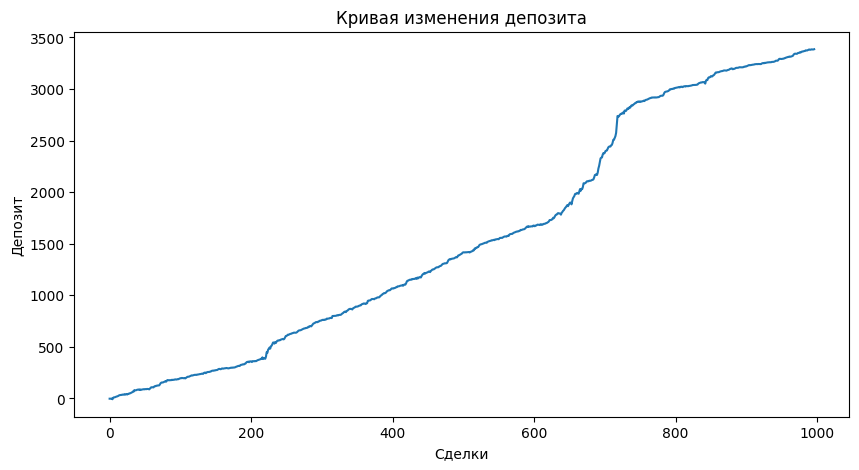

In [112]:
plt.figure(figsize=(10, 5))
eq = []
depo = 0
for i in results['res']:
    depo = depo + i
    eq.append(depo)
    
plt.title('Кривая изменения депозита')
plt.xlabel('Сделки')   
plt.ylabel('Депозит')        
plt.plot(eq)
plt.show()

# Классификации

Попробуем использовать модели классификации для предсказания цена закрытия будет выше или ниже открытия. Обучим сразу несколько моделей "из коробки"

In [113]:
data2 = data1.copy()
# определим целевой признак для классификации - закрытие выше (1) или ниже (0) "сегодняшнего" открытия
data2['TARGET_UP_DOWN'] = data2.apply(lambda x: 1 if x['TARGET_CLOSE'] > x['OPEN_TODAY'] else 0,  axis=1)
data2.head(5)

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,TARGET_CLOSE,TARGET_HIGH,TARGET_LOW,DIF_O_C,...,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,TARGET_UP_DOWN
5,2010-01-18,87.86000,90.65000,87.79000,90.49000,179399350,92.02000,92.20000,88.80000,-2.63000,...,0,0,0,0,0,0,0,0,0,1
6,2010-01-19,90.52000,92.20000,88.80000,92.02000,268915291,90.62000,92.49000,90.42000,-1.50000,...,0,0,0,0,0,0,0,0,0,0
7,2010-01-20,92.02000,92.49000,90.42000,90.62000,220273259,89.18000,91.65000,88.92000,1.40000,...,0,0,0,0,0,0,0,0,0,0
8,2010-01-21,91.26000,91.65000,88.92000,89.18000,219353508,86.50000,89.06000,85.75000,2.08000,...,0,0,0,0,0,0,0,0,0,0
9,2010-01-22,88.46000,89.06000,85.75000,86.50000,221223200,88.07000,88.80000,85.33000,1.96000,...,0,0,0,0,0,0,0,0,0,1


In [114]:
data2.TARGET_UP_DOWN.value_counts()

0    1709
1    1613
Name: TARGET_UP_DOWN, dtype: int64

Закрытий по обе стороны примерно одинаковое количество.

In [115]:
# предикторы
X = data2.drop(columns=['DATE', 'TARGET_CLOSE', 'TARGET_HIGH', 'TARGET_LOW',  'TARGET_UP_DOWN'])
# целевой признак
y = data2['TARGET_UP_DOWN']

# разделим на трейн и тест без перемешивания
# учимся на более ранних данных, тестируем на более поздних
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [116]:
cls_models = [
            LogisticRegression(random_state=10),
            RandomForestClassifier (random_state=10),
            LinearDiscriminantAnalysis(),
            KNeighborsClassifier(),
            GaussianNB(),
            SVC(random_state=10),
            GradientBoostingClassifier(random_state=10),
            LGBMClassifier(random_state=10),
            XGBClassifier(random_state=10)
            ]

In [117]:
# для записи метрик качества (будем считать accuracy) моделей
cls_models_metrics = pd.DataFrame(columns=['model', 'acc'])

for i, model in enumerate(cls_models):
    print(model, end = '..........')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)    
    acc_ = acc (y_test[:-1], y_pred[:-1])
    cls_models_metrics.loc[len(cls_models_metrics.index)] = [model, acc_]
    #models_close[f'close_pred_{i}'] = y_pred
    print('Ok')
cls_models_metrics  

LogisticRegression(random_state=10)..........Ok
RandomForestClassifier(random_state=10)..........Ok
LinearDiscriminantAnalysis()..........Ok
KNeighborsClassifier()..........Ok
GaussianNB()..........Ok
SVC(random_state=10)..........Ok
GradientBoostingClassifier(random_state=10)..........Ok
LGBMClassifier(random_state=10)..........Ok
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_job

,model,acc
0,LogisticRegression(random_state=10),0.49598
1,"(DecisionTreeClassifier(max_features='sqrt', r...",0.50703
2,LinearDiscriminantAnalysis(),0.52309
3,KNeighborsClassifier(),0.50602
4,GaussianNB(),0.50803
5,SVC(random_state=10),0.50803
6,([DecisionTreeRegressor(criterion='friedman_ms...,0.51908
7,LGBMClassifier(random_state=10),0.54819
8,"XGBClassifier(base_score=None, booster=None, c...",0.52711


Метрика accuracy чуть-чуть превышает 0,5. Предсказывать получается чуть лучше, чем случайно.\
Посмотроим roc-кривую для одной из моделей.

In [118]:
clf = LGBMClassifier(random_state=10)
clf.fit(X_train, y_train)

LGBMClassifier(random_state=10)

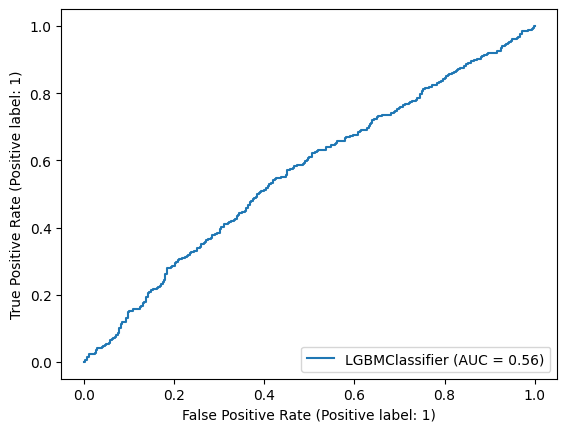

In [119]:
RocCurveDisplay.from_estimator(clf, X_test, y_test)